Homework 01 - Designing Blockchain

In [1]:
# preparation

import hashlib, random, datetime
from datetime import date
import time
import ipyparallel, numpy, matplotlib

In [2]:
class Block:
    def __init__(self, Index, Timestamp, data, previous_hash) -> None:
        self.index = Index
        self.timestamp = Timestamp
        self.data = data
        self.previous_hash = previous_hash
        self.nonce = 0
        self.hash = self.blockHash()
    
    def blockHash(self):
        
        string = str(self.index).encode('utf-8') + str(self.timestamp).encode('utf-8') + str(self.data).encode('utf-8') + str(self.previous_hash).encode('utf-8') + str(self.nonce).encode('utf-8')
    
        return hashlib.sha256(string).hexdigest()
    
    
    

        

# 1. Blockchain Data Structure

In [3]:
def block_validation(index, block_time, data, previous_hash):
    new_block = Block(index, block_time, data, previous_hash)
    check_string = '260b5039394689051b599484df495d79a6a33d22a3ca37af72656d8cdfc6fcd5'
    print_statement = "This is a valid Block" if str(new_block.hash) == check_string else "Please Check your work, this is incorrect."
    print(print_statement)
    
block_time = '2022-02-13 23:59:00'
data = 'Blockchain For Data Science'
previous_hash = '9136cfeb0c77b41e1e86cb9940ca9bb65f7aca4e8e366a8ecf9226b735e0c323'
index = 1
    
block_validation(index, block_time, data, previous_hash)

This is a valid Block


# 2. Creating a chain out of single blocks

In [4]:
def genesis_block():
    return Block(0, datetime.datetime.now(), "Genesis Block", "0")
    
def new_block(Last_block):
    index = Last_block.index + 1
    timestamp = datetime.datetime.now()
    data = f"Block {index} generated"
    previous_hash = Last_block.hash
    return Block(index, timestamp, data, previous_hash)

In [5]:
def next_block(block):
    return new_block(block)

In [6]:
def genesis_validation(genesis_block):
    block_1 = next_block(genesis_block)
    if block_1.index == 1 and block_1.data == "Block 1 generated" and block_1.previous_hash == genesis_block.hash and str(type(block_1.timestamp)) == "<class 'datetime.datetime'>":
        print("Valid Genesis block" )
    else:
        print("Check the code, not a valid genesis block:(")
        
genesis_validation(genesis_block())

Valid Genesis block


# 3. Generating a complete Blockchain

In [7]:
def complete_chain(blockchain, previous_block, num_blocks):
    
     for i in range(num_blocks):
        added_block = new_block(previous_block)
        blockchain.append(added_block)
        previous_block = added_block

        print("The block #{} is added to the blockchain".format(added_block.index))
        print("Hash : {}\n".format(added_block.hash))

# Initialize the blockchain with the genesis block
blockchain = [genesis_block()]
previous_block = blockchain[0]
num_blocks = 10

# Generate and print the chain with 10 blocks
complete_chain(blockchain, previous_block, num_blocks)

The block #1 is added to the blockchain
Hash : c5fc674d338b8955fa3c1dbb745ea34d1c59ced631734c6c3e6bfffe3b33572e

The block #2 is added to the blockchain
Hash : f171ca07036bbc3881833a0945a94ad5b99a2b2a82729ffe04b5ea22cdd5bd24

The block #3 is added to the blockchain
Hash : 1cf5c466e176ebee715e2bdba8bf666efb9005cbbf5ea4b7ad57405c946942f0

The block #4 is added to the blockchain
Hash : e7ca2595be48a37e83a5f3094a1ab551544438174c1da1c4caf5e64304ea26c1

The block #5 is added to the blockchain
Hash : 9a51f1e80db08dad44dedfcd768a345ad8162c284cfa82b0df88b419c97f452c

The block #6 is added to the blockchain
Hash : a5a722337c77a252f8cc238f7a40694a0236ae7b33d16264a8cba3c9d3a81e9d

The block #7 is added to the blockchain
Hash : e61552b1140f7c03b0a9eabbabc0925231be4fffd8dcf44d5b41f6ecd8b73885

The block #8 is added to the blockchain
Hash : 55d290eb15cf542a34955abb55ba509df30baf5a5a5aefb435cff5e379636ea2

The block #9 is added to the blockchain
Hash : f5480c9c308f1d16e60be61857bcdc2b6636d78d2aa638cdd

In [8]:
len(blockchain)

11

## 4. Nonce and Difficulty

### 4.1. Define function generate_nonce()

#### 4.1.1
Limitation: the randint can be set seeded thus, the randomness is not guranteed. Since we are using this for larget scale generation, different miners might try out the same result during their mining; which is not reasonable and wasting computation power. 

In [9]:
# by the second method
import secrets
def generate_nonce(n = 10):
    return secrets.token_urlsafe(n)

#### 4.1.3
other approach:  
By OS module, we can use the randomness value from the system base.  
Weakness for windos os generatior: https://www.cs.huji.ac.il/~dolev/pubs/thesis/msc-thesis-leo.pdf

### 4.2 Define function generate_difficulty_bound()

In [10]:
def generate_difficulty_bound(difficulty=1):
    difficulty_hash = ""
    
    difficulty_hash += "0" * difficulty + "F" * (64 - difficulty)
    
    difficulty_hash = "0x" + difficulty_hash
    # print(difficulty_hash)
    result = int(difficulty_hash, base = 16)
    # print(result)
    # print(hex(result))
    return result

### 4.3 Engineer a nonce given the previous block’s hash and difficulty

In [11]:
def find_next_block(last_block, difficulty, nonce_length):
    start_time = time.process_time()
    difficulty_bound = generate_difficulty_bound(difficulty)
    new_block = next_block(last_block)
    hashtried = 1

    while int(new_block.hash, 16) > difficulty_bound:
        old = new_block.hash
        nonce = generate_nonce(nonce_length)
        new_block = Block(new_block.index, new_block.timestamp, new_block.data, new_block.previous_hash)
        new_block.nonce = nonce
        new_block.hash = new_block.blockHash()
        # if new_block.hash == old:
        #     print("not ")
        #     raise ValueError
        hashtried += 1

    time_taken = time.process_time() - start_time
    return time_taken, hashtried, new_block

### 4.4 Blockchain with proof of work

In [12]:
def create_blockchain(num_blocks, difficulty, blockchain, previous_block, nonce_length, broadcast=1):
    hash_array = []
    time_array = []

    for i in range(num_blocks):
        timetaken, hashtried, block_to_add = find_next_block(previous_block, difficulty, nonce_length)
        blockchain.append(block_to_add)
        previous_block = block_to_add
        hash_array.append(hashtried)
        time_array.append(timetaken)

        if broadcast:
            print(f"Block number: {block_to_add.index}")
            if broadcast == 1:
                print(f"Number of hashes tried: {hashtried}")
                print(f"Time to find the block: {timetaken}")
                print(f"Hash of the current block: {block_to_add.hash}")

    return hash_array, time_array

In [13]:
def create_genesis_block():
    return genesis_block()

In [14]:
blockchain = [create_genesis_block()]
previous_block = blockchain[0]
num_blocks = 20
difficulty = 3        # PS from HW instruction "(I chose 7, and my stupid blockchain took half an hour to generate)"
nonce_length = 10

In [15]:
create_blockchain(num_blocks, difficulty, blockchain, previous_block, nonce_length, broadcast= 2)

Block number: 1
Block number: 2
Block number: 3
Block number: 4
Block number: 5
Block number: 6
Block number: 7
Block number: 8
Block number: 9
Block number: 10
Block number: 11
Block number: 12
Block number: 13
Block number: 14
Block number: 15
Block number: 16
Block number: 17
Block number: 18
Block number: 19
Block number: 20


([87,
  6517,
  1559,
  2980,
  1535,
  2726,
  6191,
  580,
  5668,
  435,
  3870,
  933,
  3169,
  2110,
  905,
  5580,
  5792,
  717,
  618,
  1000],
 [0.002473999999999865,
  0.03874399999999989,
  0.009113999999999844,
  0.016440999999999928,
  0.00842799999999988,
  0.015045999999999893,
  0.03398800000000035,
  0.0032169999999998034,
  0.031160999999999994,
  0.002422999999999842,
  0.02160900000000021,
  0.0050240000000001395,
  0.017406000000000255,
  0.012492999999999643,
  0.006629000000000218,
  0.03273799999999971,
  0.03343200000000035,
  0.003996000000000333,
  0.0034000000000000696,
  0.005586000000000091])

In [16]:
def blockchain_proof(blockchain, num_blocks):
    correct = True
    bound = generate_difficulty_bound(difficulty)
    if len(blockchain) != num_blocks + 1:
        # print("1")
        correct = False
    for i in range(len(blockchain) - 1):
        if blockchain[i + 1].previous_hash != blockchain[i].hash:
            print("1")
            correct = False
            break
        if int(blockchain[i + 1].hash, 16) > bound:
            print("2")
            correct = False
            break
    print_statement = "PASSED!!! Move on to the next Part" if correct else "FAILED!!! Try Again :("
    print(print_statement)
            
blockchain_proof(blockchain, num_blocks)

PASSED!!! Move on to the next Part


## 5 Distributed Network

In [17]:
class MinerNodeNaive: 
    def __init__(self, name, compute):
        self.name = name 
        self.compute = compute
    
    def try_hash(self, diff_value, chain):
        last_block = chain[-1]
        difficulty = generate_difficulty_bound(diff_value)
        date_now = datetime.datetime.now()
        this_index = last_block.index + 1
        this_timestamp = date_now
        this_data = "Hey! I'm block " + str(this_index)
        this_hash = last_block.hash
        new_block = Block(this_index, this_timestamp, this_data, this_hash)
        if int(new_block.hash, 16) < difficulty:
            chain.append(new_block)
            # Tell everyone about it!
            print("Block #{} has been added to the blockchain!".format(new_block.index))
            print("Block found by: {}".format(self.name))
            print("Hash: {}\n".format(new_block.hash))
            return True
        return False

The entire class:   
First initinate an instance for miner.    
The second function used for mining, trying to find the next valid new block of the block chain. But only try to find one. It is a start of tring, if the first time success, it output the success result. But, if not success, it ended.    
The name is for identitfy and the compute is for specify whcih to perform the work.     


### 5.1 Generate multiple mining peers


In [19]:
comp_pow = [random.randint(1,10) for i in range(5)]
miners_name = [f"mine{i+1}" for i in range(5)]
miners = [MinerNodeNaive(miners_name[i], comp_pow[i]) for i in range(5)]

In [20]:
miners

### 5.2 Create a compute and mining simulation

In [21]:
def compute_simulation(miners):
    com_array = []

    # Create a random peer group based on miners' compute power
    for miner in miners:
        com_array.extend([miner for i in range(len(miners))])

    # Return the compute array
    return com_array

### 5.3 Difficulty list

In [22]:
difficult_list = [random.randint(1, 3) for i in range(len(blockchain))]

### 5.4 Simulation


In [23]:
numblocks = 10
blockchain = [create_genesis_block()]
genesis = blockchain[0]
difficulty_list = difficult_list


In [34]:
com_array = compute_simulation(miners)

for i in range(numblocks):
    next_miner_name = "miner2"
    sample_miner = random.choice(com_array)
    
    for miner in miners:
        if miner.name == sample_miner.name:
            next_miner = miner
            break
    result = False
    while not result:
        result = next_miner.try_hash(difficult_list[i], chain= blockchain)
    
    
    

Block #2 has been added to the blockchain!
Block found by: mine1
Hash: 00425c365a3e09fdcc6e5acd3e6111e241bf51c0dc6bac8e844c711fbdc7f17e

Block #3 has been added to the blockchain!
Block found by: mine4
Hash: 003c23b9f7afbe04a98955f3d9a960445029ca7de2a254b2176e416121f9b255

Block #4 has been added to the blockchain!
Block found by: mine4
Hash: 03752bec3fd0ec574b05b8a3f02d7e2037dab5f1616e0b3ae201545f2f6580df

Block #5 has been added to the blockchain!
Block found by: mine1
Hash: 099ae8e853beae5bd4dc8d7859df99a76e836b7570424657cacc0f7dae5e7cfd

Block #6 has been added to the blockchain!
Block found by: mine1
Hash: 0620fb410850db0cb77933cca119a46fd9859f73dc2bb7de356ef80db83febf3

Block #7 has been added to the blockchain!
Block found by: mine3
Hash: 0006cea1cdf47dc4c26bab22d0dd8fe1d53e2ad33c2c6517235313913de9a980

Block #8 has been added to the blockchain!
Block found by: mine5
Hash: 0007b7750acd93373271f1c1266eedad81fddc0597a190ffc697769a877377d8

Block #9 has been added to the blockchain

## 6 Analytics on the Blockchain Data


In [35]:
blockchain = [create_genesis_block()]
previous_block = blockchain[0]
num_blocks = 40
nonce_len = 20
difficulty = [1 ,2, 3, 4, 5]

In [40]:
hash_arrays = [i for i in range(len(difficulty))]
time_arrays = [i for i in range(len(difficulty))]

for i in range(len(difficulty)):
    blockchain = [create_genesis_block()]
    previous_block = blockchain[0]
    hash_arrays[i], time_arrays[i] = create_blockchain(num_blocks, difficulty[i], blockchain, previous_block, nonce_len, )

Block number: 1
Number of hashes tried: 10
Time to find the block: 0.0006369999999997766
Hash of the current block: 0c24bb1ce55e33518daaaf4779fb7d758dc659a77ed2aa1072650701bcb792d2
Block number: 2
Number of hashes tried: 54
Time to find the block: 0.0009329999999998506
Hash of the current block: 01ddf5c5e33e294f4c2e99cc1acdf1fb464b8c99fdf2579d00f85ad8d26c64e1
Block number: 3
Number of hashes tried: 1
Time to find the block: 7.999999999785956e-06
Hash of the current block: 0298fd0b3d767230370961130d8d230c617ee4220d50d6f140a00507a9755a2d
Block number: 4
Number of hashes tried: 11
Time to find the block: 0.000124000000000013
Hash of the current block: 00380f7060fc7f27688cc5ed608c0fae5436e254e0c55fefea53aefb70c7c0b0
Block number: 5
Number of hashes tried: 4
Time to find the block: 3.900000000012227e-05
Hash of the current block: 06bd7ec7f50918f886ea9e73b187b5a45ef7f746a701fde3520b42704daaecc6
Block number: 6
Number of hashes tried: 24
Time to find the block: 0.0003329999999999167
Hash of t

In [42]:
import matplotlib.pyplot as plt

### 6.2 

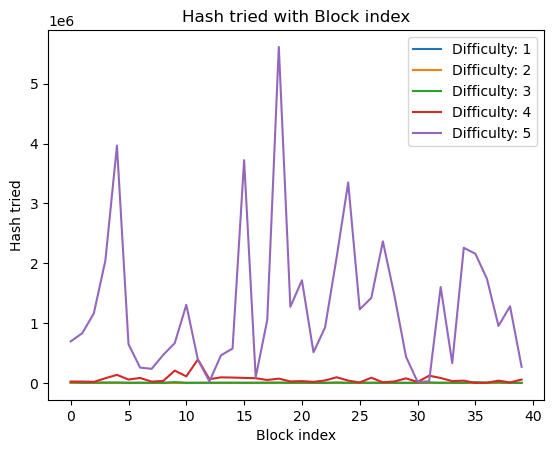

In [62]:
for i in range(len(difficulty)):
    plt.plot(hash_arrays[i], label = f'Difficulty: {difficulty[i]}')

plt.title('Hash tried with Block index')
plt.xlabel('Block index')
plt.ylabel('Hash tried')
plt.legend()


### 6.3 

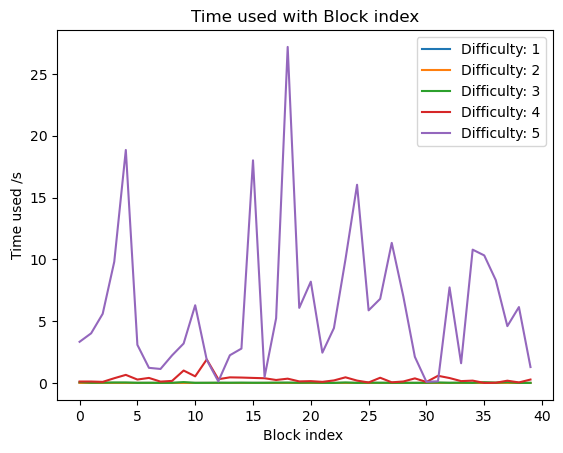

In [64]:
for i in range(len(difficulty)):
    plt.plot(time_arrays[i], label = f'Difficulty: {difficulty[i]}')

plt.title('Time used with Block index')
plt.xlabel('Block index ')
plt.ylabel('Time used /s')
plt.legend()


### 6.4 

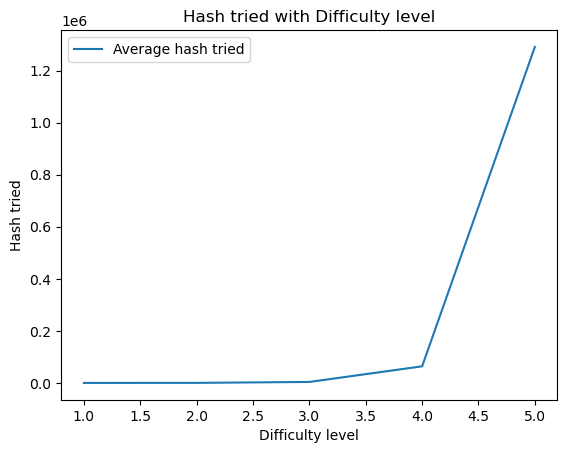

In [65]:
plt.plot(difficulty, [sum(i)/len(i) for i in hash_arrays], label = "Average hash tried")

plt.title('Hash tried with Difficulty level')
plt.xlabel('Difficulty level')
plt.ylabel('Hash tried')
plt.legend()


### 6.5 

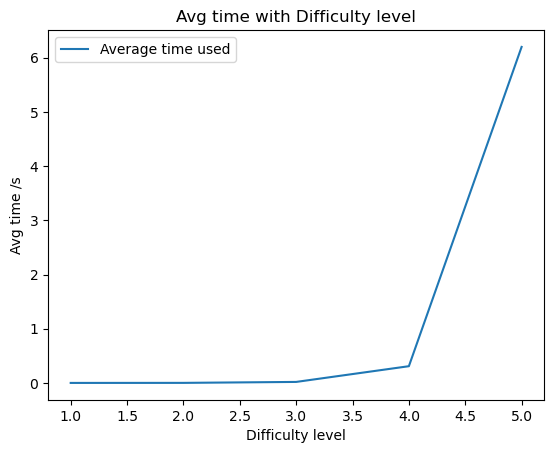

In [66]:
plt.plot(difficulty, [sum(i)/len(i) for i in time_arrays], label = "Average time used")

plt.title('Avg time with Difficulty level')
plt.xlabel('Difficulty level')
plt.ylabel('Avg time /s')
plt.legend()
